In [1]:
%matplotlib notebook

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoGuideList, AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal, AutoDiscreteParallel 
from pyro.infer.autoguide import init_to_mean, init_to_uniform
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS

from torch.distributions import constraints
import torch
import numpy as np
from matplotlib import pyplot
import pandas as pd

import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

#pyro.enable_validation(True) 

In [2]:
nPerson = 2
nModesPerPerson = 3
nSpectralCoeff = 2
nSamplesPerMode = 4

modeCovarianceFactor = 100
personCovarianceFactor = 1
dataCovarianceFactor = .01

modeMean = torch.zeros(nSpectralCoeff)
modeCovariance = modeCovarianceFactor * torch.eye(nSpectralCoeff)
personCovariance = personCovarianceFactor * torch.eye(nSpectralCoeff)
dataCovariance = dataCovarianceFactor * torch.eye(nSpectralCoeff)

In [3]:
def generateData(nPerson, nModesPerPerson, nSpectralCoeff, nSamplesPerMode):
    modeLocs = {}
    locs = {}
    data = []
    personIndex = []
    
    for thisMode in pyro.plate("modeLoc_loop", nModesPerPerson):
        modeLocName = "modeLoc_" + str(thisMode)
        thisModeLoc = pyro.sample(modeLocName, dist.MultivariateNormal(modeMean, modeCovariance))
        modeLocs[modeLocName] = thisModeLoc
        
        for thisPerson in pyro.plate("person_loop", nPerson):
            locName = "locModePerson_" + str(thisMode) + "_" + str(thisPerson)
            thisLoc = pyro.sample(locName, dist.MultivariateNormal(thisModeLoc, personCovariance))
            locs[locName] = thisLoc

            for thisDataSample in pyro.plate("data_loop", nSamplesPerMode):
                dataName = "dataMPS_" + str(thisMode) + "_" + str(thisPerson) + "_" + str(thisDataSample)
                thisDatum = pyro.sample(dataName, dist.MultivariateNormal(thisLoc, dataCovariance)).numpy()
                data.append(thisDatum)
                personIndex.append(thisPerson)
    
    return modeLocs, locs, np.hstack((np.expand_dims(np.array(personIndex).transpose(),1), np.array(data)))

# Generate fake data

In [4]:
#pyro.set_rng_seed(1)
pyro.clear_param_store()
modeLocsTrue, locsTrue, data = generateData(nPerson, nModesPerPerson, nSpectralCoeff, nSamplesPerMode)

# Plot fake data

{'modeLoc_0': tensor([-3.9704, -8.7482]), 'modeLoc_1': tensor([-6.5921,  1.3654]), 'modeLoc_2': tensor([ 13.5098, -10.5740])}

{'locModePerson_0_0': tensor([-3.2228, -7.8292]), 'locModePerson_0_1': tensor([ -4.8053, -10.5050]), 'locModePerson_1_0': tensor([-6.7407,  0.6513]), 'locModePerson_1_1': tensor([-5.9580,  1.3384]), 'locModePerson_2_0': tensor([ 12.5703, -11.2529]), 'locModePerson_2_1': tensor([13.3551, -9.9778])}


<IPython.core.display.Javascript object>


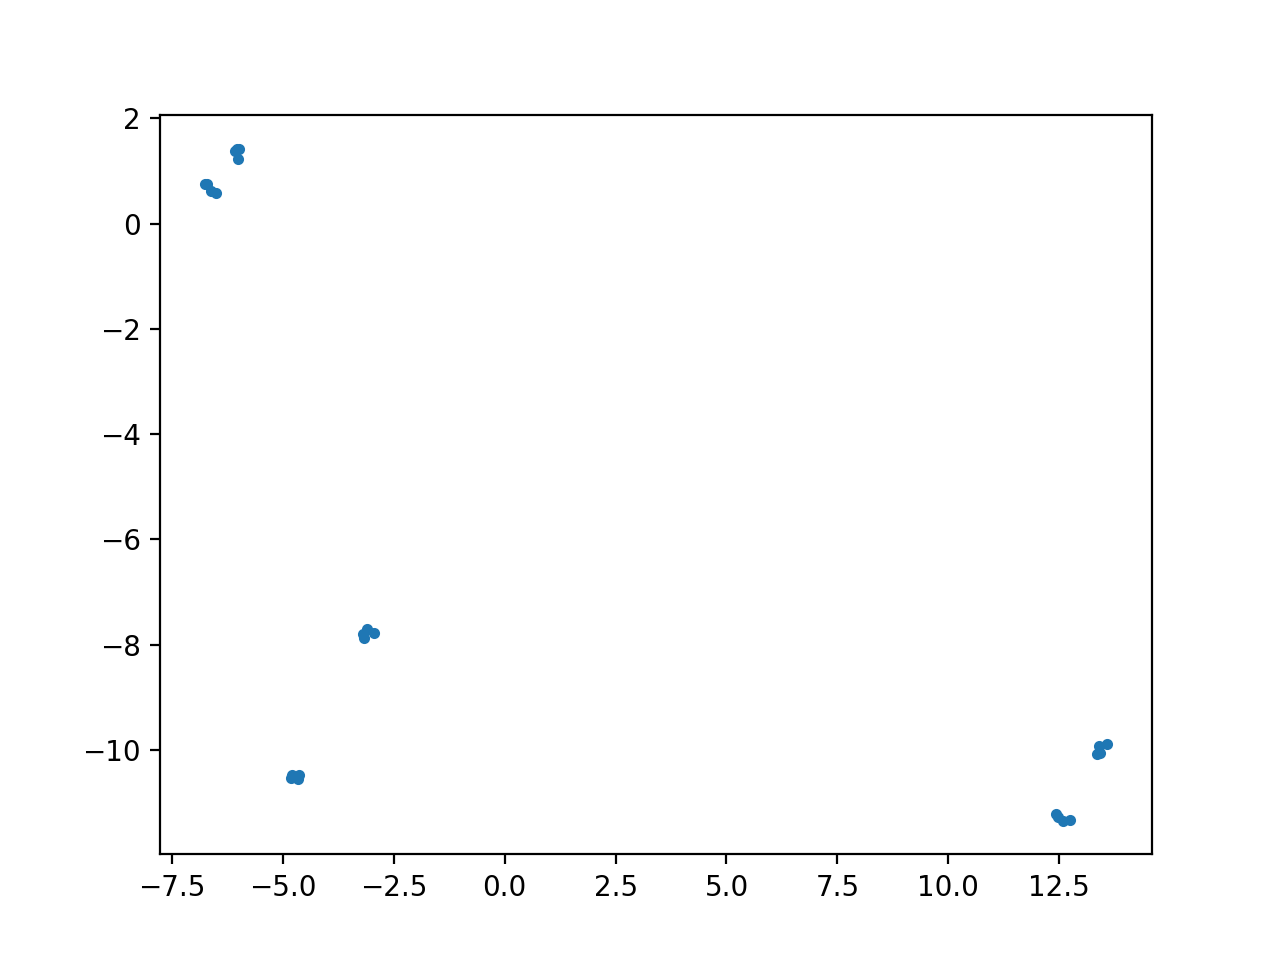

In [5]:
person = torch.tensor(np.cast['int'](data[:,0]))
samples = torch.tensor(data[:,1:]).float()
print(modeLocsTrue)
print()
print(locsTrue)

pyplot.figure()
pyplot.plot(data[:,1], data[:,2],'.')

In [6]:
@config_enumerate
def model(person, sample):
    
    loc = torch.zeros(size=(nModesPerPerson, nPerson, nSpectralCoeff))
    
    for thisMode in range(nModesPerPerson):
        modeLocName = "modeLoc_" + str(thisMode)
        thisModeLoc = pyro.sample(modeLocName, dist.MultivariateNormal(modeMean, modeCovariance))
        
        for thisPerson in range(nPerson):
            locName = "locModePerson_" + str(thisMode) + "_" + str(thisPerson)
            thisLoc = pyro.sample(locName, dist.MultivariateNormal(thisModeLoc, personCovariance))

            loc[thisMode, thisPerson, :] = thisLoc
    
    with pyro.plate('data_loop', len(person)):
        modeAssignment = pyro.sample('modeAssignment', 
                                     dist.Categorical((1./nModesPerPerson) * torch.ones(nModesPerPerson)))
        
        pyro.sample('obs', 
                    dist.MultivariateNormal(loc[modeAssignment, person, :], dataCovariance), 
                    obs=sample)
    

In [9]:
modeLocList = ["modeLoc_" + str(i) for i in range(nModesPerPerson)]
locModePersonList = ["locModePerson_" + str(i) + "_" + str(j) for i in range(nModesPerPerson) for j in range(nPerson)]

guideFlag = 3

if guideFlag == 0:
    
    guide = AutoGuideList(model)
    guide.append(AutoDelta(poutine.block(model, hide=['modeAssignment']), init_loc_fn=init_to_uniform(radius=10)))
    guide.append(AutoDiscreteParallel(poutine.block(model, expose=["modeAssignment"])))
    
elif guideFlag == 1:
    
    guide = AutoGuideList(model)
    guide.append(AutoDiagonalNormal(poutine.block(model, hide=['modeAssignment'])))#, init_loc_fn=init_to_mean)
    guide.append(AutoDiscreteParallel(poutine.block(model, expose=["modeAssignment"])))
    
elif guideFlag == 2:
    
    guide = AutoGuideList(model)
    guide.append(AutoMultivariateNormal(poutine.block(model, hide=['modeAssignment'])))
    guide.append(AutoDiscreteParallel(poutine.block(model, expose=["modeAssignment"])))
    
elif guideFlag == 3:
    
    def guide(person, sample):

        modeLoc = [0 for i in range(nModesPerPerson)]
        locModePerson = [[0 for i in range(nPerson)] for j in range(nModesPerPerson)]
        
        for thisMode in range(nModesPerPerson):
            
            modeLocName = "modeLoc_" + str(thisMode)
            
            #modeLoc[thisMode] = pyro.param('a{}'.format(thisMode), modeCovarianceFactor * torch.rand(nSpectralCoeff))
            modeLoc[thisMode] = pyro.param('a{}'.format(thisMode), modeLocsTrue[modeLocName].clone())
            pyro.sample(modeLocName, dist.MultivariateNormal(modeLoc[thisMode], modeCovariance))
        
            for thisPerson in range(nPerson):
                
                locName = "locModePerson_" + str(thisMode) + "_" + str(thisPerson)
                #locModePerson[thisMode][thisPerson] = pyro.param('b{}{}'.format(thisMode,thisPerson), personCovarianceFactor * torch.rand(nSpectralCoeff))
                locModePerson[thisMode][thisPerson] = pyro.param('b{}{}'.format(thisMode,thisPerson), locsTrue[locName].clone())
                
                pyro.sample(locName, dist.MultivariateNormal(locModePerson[thisMode][thisPerson], personCovariance))

        #phi = pyro.param('phi', (1./nModesPerPerson) * torch.ones(nModesPerPerson), constraint=constraints.cat())
        modeAssignment = pyro.sample("modeAssignment", 
                                     dist.Categorical((1./nModesPerPerson) * torch.ones(nModesPerPerson)))
            
            
optim = pyro.optim.Adam({'lr': 0.05})
elbo = TraceEnum_ELBO()
svi = SVI(model, guide, optim, loss=elbo)

In [ ]:
pyro.clear_param_store()

num_iters = 5000 
losses = []

for i in range(num_iters):
    loss = svi.step(person, samples)
    losses.append(loss)
    if i % 500 == 0:
        print("Elbo loss: {}".format(loss))

In [ ]:
pyplot.figure(dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

In [8]:
print(modeLocsTrue)
print()
print(locsTrue)

{'modeLoc_0': tensor([-3.9704, -8.7482]), 'modeLoc_1': tensor([-6.5921,  1.3654]), 'modeLoc_2': tensor([ 13.5098, -10.5740])}

{'locModePerson_0_0': tensor([-3.2228, -7.8292]), 'locModePerson_0_1': tensor([ -4.8053, -10.5050]), 'locModePerson_1_0': tensor([-6.7407,  0.6513]), 'locModePerson_1_1': tensor([-5.9580,  1.3384]), 'locModePerson_2_0': tensor([ 12.5703, -11.2529]), 'locModePerson_2_1': tensor([13.3551, -9.9778])}


In [ ]:
try:
    guide.quantiles(np.linspace(.1,.9,9))
except:
    pass

In [ ]:
list(pyro.get_param_store().items())

In [ ]:
from pyro.infer import Predictive

num_samples = 5
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.detach().cpu().numpy() for k, v in predictive(person, samples).items() if k != "obs"}
svi_samples

# MCMC

In [ ]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=5000, warmup_steps=500)
mcmc.run(person, samples)
posterior_samples = mcmc.get_samples()

In [ ]:
posterior_samples.keys()

In [ ]:
print(modeLocsTrue)
print()
print(locsTrue)

In [ ]:
variable = 'modeLoc_2'

X = posterior_samples[variable][:,0]
Y = posterior_samples[variable][:,1]

In [ ]:
pyplot.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
h, xs, ys, image = pyplot.hist2d(X.numpy(), Y.numpy(), bins=[20, 20])
pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
               colors='white', alpha=0.8)
pyplot.title('Posterior density as estimated by collapsed NUTS')
pyplot.xlabel('loc of component 0')
pyplot.ylabel('loc of component 1')
pyplot.tight_layout()

# Eight schools example

In [ ]:


import torch
from torch.distributions import constraints, transforms

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO
from pyro.optim import Adam

#logging.basicConfig(format='%(message)s', level=logging.INFO)

J = 8
y = torch.tensor([28,  8, -3,  7, -1,  1, 18, 12]).type(torch.Tensor)
sigma = torch.tensor([15, 10, 16, 11,  9, 11, 10, 18]).type(torch.Tensor)
data = torch.stack([y, sigma], dim=1)


def model(data):
    y = data[:, 0]
    sigma = data[:, 1]

    with pyro.plate("data", J):
        eta = pyro.sample('eta', dist.Normal(torch.zeros(J), torch.ones(J)))
        mu = pyro.sample('mu', dist.Normal(torch.zeros(1), 10 * torch.ones(1)))
        tau = pyro.sample('tau', dist.HalfCauchy(scale=25 * torch.ones(1)))

        theta = mu + tau * eta

        pyro.sample("obs", dist.Normal(theta, sigma), obs=y)


def guide(data):
    loc_eta = torch.randn(J)
    # note that we initialize our scales to be pretty narrow
    scale_eta = 0.1 * torch.rand(J)
    loc_mu = torch.randn(1)
    scale_mu = 0.1 * torch.rand(1)
    loc_logtau = torch.randn(1)
    scale_logtau = 0.1 * torch.rand(1)

    # register learnable params in the param store
    m_eta_param = pyro.param("loc_eta", loc_eta)
    s_eta_param = pyro.param("scale_eta", scale_eta, constraint=constraints.positive)
    m_mu_param = pyro.param("loc_mu", loc_mu)
    s_mu_param = pyro.param("scale_mu", scale_mu, constraint=constraints.positive)
    m_logtau_param = pyro.param("loc_logtau", loc_logtau)
    s_logtau_param = pyro.param("scale_logtau", scale_logtau, constraint=constraints.positive)

    # guide distributions
    dist_eta = dist.Normal(m_eta_param, s_eta_param)
    dist_mu = dist.Normal(m_mu_param, s_mu_param)
    dist_tau = dist.TransformedDistribution(dist.Normal(m_logtau_param, s_logtau_param),
                                            transforms=transforms.ExpTransform())

    with pyro.plate("data", J):
        pyro.sample('eta', dist_eta)
        pyro.sample('mu', dist_mu)
        pyro.sample('tau', dist_tau)



optim = Adam({'lr': .05})
elbo = Trace_ELBO()
svi = SVI(model, guide, optim, loss=elbo)

pyro.clear_param_store()
for j in range(1000):
    loss = svi.step(data)
    if j % 100 == 0:
        print("[epoch %04d] loss: %.4f" % (j + 1, loss))

for name, value in pyro.get_param_store().items():
    print(name)
    print(value.detach().cpu().numpy())


# Scratch

In [ ]:
def guide(person, sample):

        for thisMode in pyro.plate("modeLoc_loop", nModesPerPerson):
            modeLocName = "modeLoc_" + str(thisMode)
            thisModeLoc = pyro.sample(modeLocName, dist.MultivariateNormal(modeMean, modeCovariance))

            for thisPerson in pyro.plate("person_loop_{}".format(thisMode), nPerson):
                locName = "locModePerson_" + str(thisMode) + "_" + str(thisPerson)
                thisLoc = pyro.sample(locName, dist.MultivariateNormal(thisModeLoc, personCovariance))

                #loc[thisMode][thisPerson] = thisLoc

        for i in pyro.plate("mode_loop", len(person)):
            modeAssignment = pyro.sample("modeAssignment_{}".format(i), 
                                         dist.Categorical((1./nModesPerPerson) * torch.ones(nModesPerPerson)))
            
    svi = SVI(model, guide, optim, loss=elbo)